In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
from astropy.io import ascii
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy_healpix import HEALPix
%matplotlib inline
import numpy as np
import os.path
import healpy
import gala

In [2]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    pole = coord.CoordinateAttribute(frame=coord.ICRS)
    roll = coord.QuantityAttribute(default=0*u.degree)


@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):

    roll = arbpole_frame.roll
    pole = arbpole_frame.pole

    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)

    return R


@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))

def plotFootprint(x, y, filename, nbins=250):
    fig2, axes = plt.subplots()#1, 3, figsize=(15, 5))
    H, xedges, yedges = np.histogram2d(x, y, bins=(nbins, nbins))
    axes.pcolormesh(xedges, yedges, H.T, norm=mpl.colors.LogNorm(vmin=10, vmax=1000))
    plt.ylabel('phi2')
    plt.xlabel('phi1')
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(10,10)
    fig.savefig(filename, rasterized=True)
    return fig2, axes

def plotStream(l, b, ra, dec, lpoles, bpoles, phi1s, filenameGal ='all.png', filenameEq = 'all.png'):
    #SNindex = (data['s2n'] <= 10) & (data['s2n'] > 5)
    figGal, axGal = plotFootprint(l, b, None, nbins=500)
    figEq, axEq = plotFootprint(ra, dec, None, nbins=500)
    phi1 = np.linspace(0, 360.00001, 1024)
    phi2 = np.zeros(len(phi1))
    for lpole, bpole, phi1mid in zip(lpoles, bpoles, phi1s):
        pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
        index = (phi1 <= phi1mid+5) & (phi1 >= phi1mid-5)
        testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
        gal = testobserved.transform_to(coord.Galactic)
        eq = testobserved.transform_to(coord.ICRS)
        axGal.scatter(gal.l, gal.b, alpha=0.1, c='black', s=1)
        axEq.scatter(eq.ra, eq.dec, alpha=0.1, c='black', s=1)
    for ax in [axGal, axEq]: ax.set_xlim(0, 360)
    axGal.set_ylim(-90, 90)
    axGal.set_xlabel('l')
    axGal.set_ylabel('b')
    axEq.set_ylim(-30, 90)
    axEq.set_xlabel('ra')
    axEq.set_ylabel('dec')
    figGal.savefig(filenameGal)
    figEq.savefig(filenameEq)

In [3]:
picklefile = 'gaiasdssHaloNew_30b_dustcorrected_python3.pkl'
with open(picklefile, 'rb') as f:
    stars = pickle.load(f)

In [4]:
#streamfile = 'detections_distance20_nside128_SN3.txt'
streamfile = 'detections_distance20_nside256_SN3_dphi2_0.25_nocmcut.txt'
data = ascii.read(streamfile, names=['l', 'b', 'phi1', 'muphi1', 's2n', 'n'])

In [5]:
data.keys()
data

l,b,phi1,muphi1,s2n,n
float64,float64,float64,float64,float64,float64
124.060773,56.446381,180.0,-12.5,3.071286,1.0
124.558011,56.446381,182.5,-12.5,3.23563,1.0
128.818681,56.255467,185.0,-12.5,3.790822,1.0
128.818681,56.255467,187.5,-12.5,3.01682,1.0
24.836066,56.064458,260.0,-11.5,3.016455,1.0
135.0,56.064458,190.0,-14.5,3.531542,1.0
135.0,56.064458,192.5,-14.5,3.034935,1.0
139.42623,56.064458,197.5,-14.5,3.455455,1.0
343.032787,56.064458,217.5,-14.5,3.415957,1.0


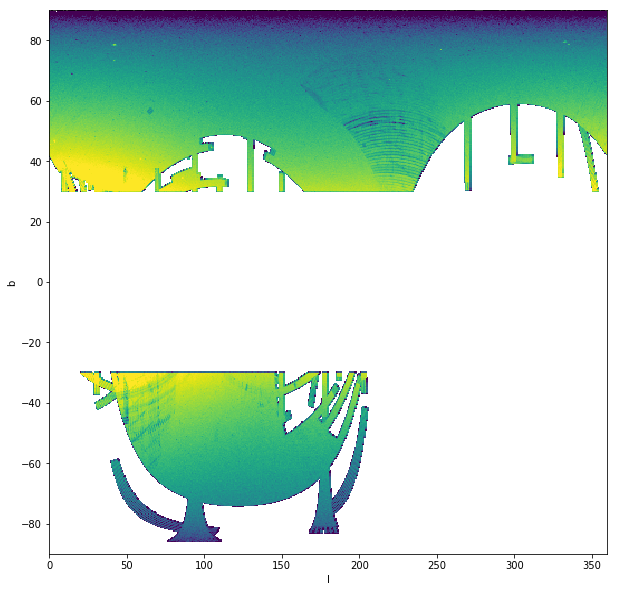

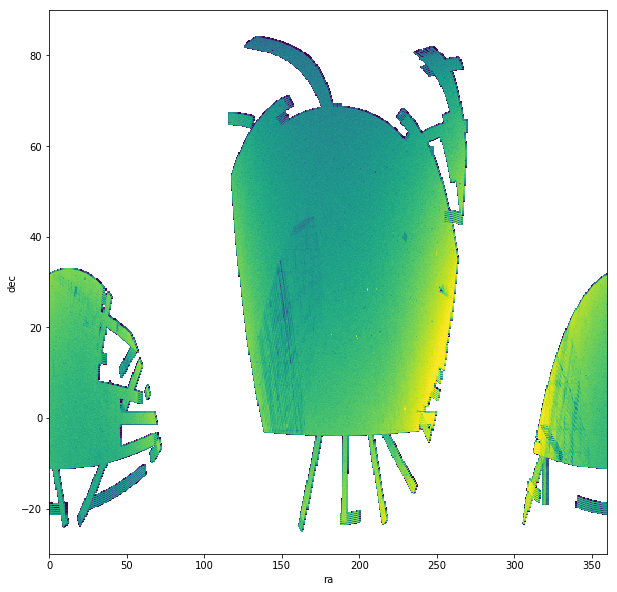

In [6]:
figGal, axGal = plotFootprint(stars['l'], stars['b'], None, nbins=500)
figEq, axEq = plotFootprint(stars['s_ra1'], stars['s_dec1'], None, nbins=500)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')

figGal.savefig('galview.png')
figEq.savefig('eqview.png')

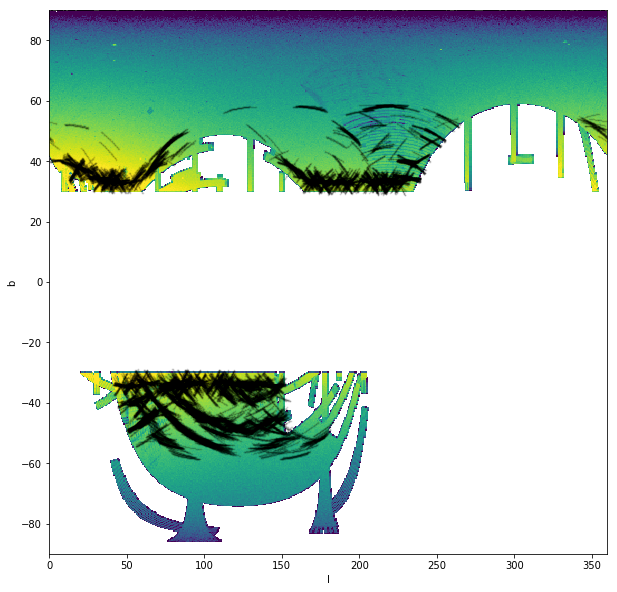

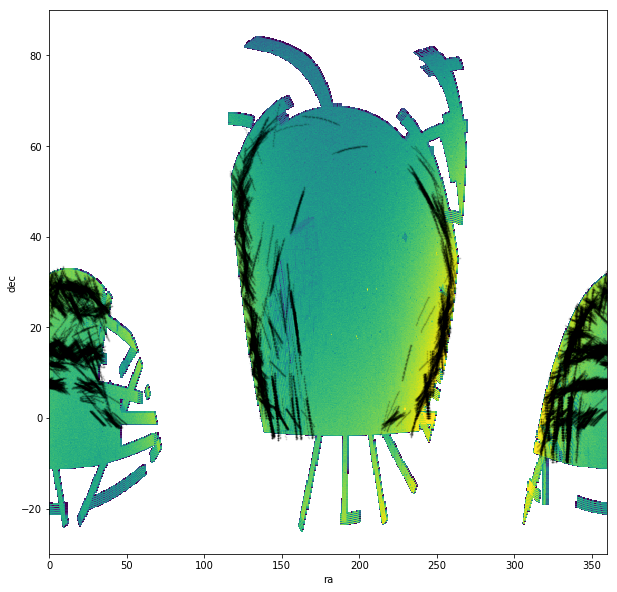

In [11]:
SNlow = [5]#[15, 10, 8, 6, 5]
SNhigh = [100000]#[100000, 15, 10, 8, 6]
for distance in ['20']:
    #streamfile = 'detections_distance' + distance + '_nside128.txt'
    #data = ascii.read(streamfile)
    for sl, sh in zip(SNlow, SNhigh):
        SNindex = data['n'] > 10
        #SNindex = (data['s2n']/data['n'] <= sh) & (data['s2n']/data['n'] > sl)
        filenameGal = 'galView_SN{0}to{1}_distance{2}kpc.png'.format(sl, sh, distance)
        filenameEq = 'eqView_SN{0}to{1}_distance{2}kpc.png'.format(sl, sh, distance)
        if not os.path.isfile(filenameEq):
            plotStream(stars['l'], stars['b'], stars['s_ra1'], stars['s_dec1'], 
                       data['l'][SNindex], data['b'][SNindex], data['phi1'][SNindex],
                       filenameGal =filenameGal, filenameEq = filenameEq)

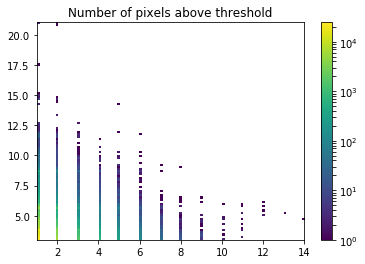

In [22]:
plt.hist2d(data['n'][~np.isinf(data['s2n'])], data['s2n'][~np.isinf(data['s2n'])], bins=100, norm=mpl.colors.LogNorm())
plt.title('Number of pixels above threshold')
plt.colorbar()

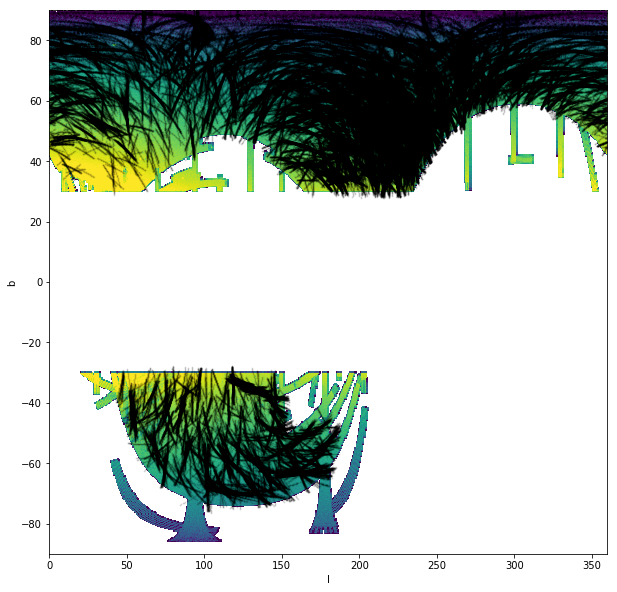

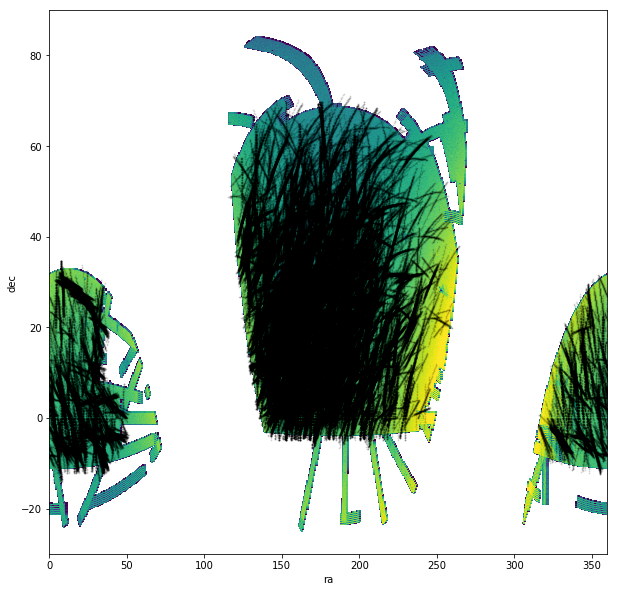

In [27]:
n_thresh = [2]
distances = ['20']
for distance in distances:
    #streamfile = 'detections_distance' + distance + '_nside128.txt'
    #data = ascii.read(streamfile)
    for nmin in n_thresh:
        index = (data['n'] <= nmin) & (data['s2n'] < 5) #& (data['s2n'] < 15)
        filenameGal = 'galView_nmax{0}_distance{1}kpc.png'.format(nmin, distance)
        filenameEq = 'eqView_nmax{0}_distance{1}kpc.png'.format(nmin, distance)
        if True: #not os.path.isfile(filenameEq):
            plotStream(stars['l'], stars['b'], stars['s_ra1'], stars['s_dec1'], 
                       data['l'][index], data['b'][index], data['phi1'][index],
                       filenameGal =filenameGal, filenameEq = filenameEq)

Text(0.5,1,'n detections')

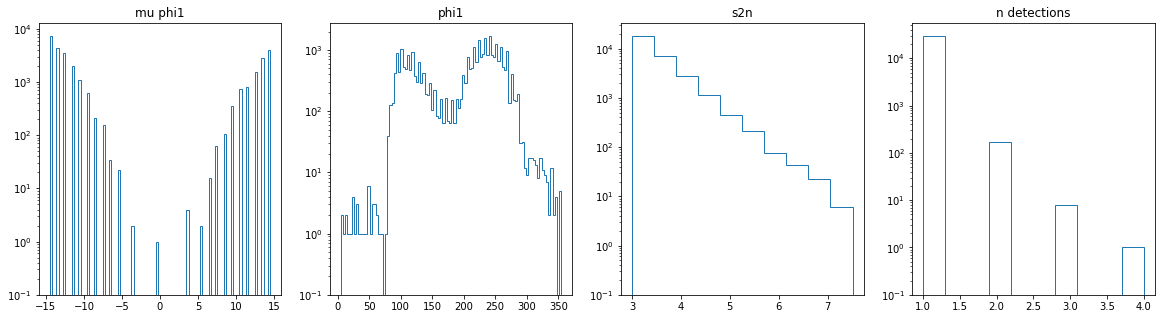

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].hist(data['muphi1'], bins=100, log=True, histtype='step')
ax[0].set_title('mu phi1')
ax[1].hist(data['phi1'], bins=100, log=True, histtype='step')
ax[1].set_title('phi1')
ax[2].hist(data['s2n'][~np.isinf(data['s2n'])], bins=10, log=True, histtype='step')
ax[2].set_title('s2n')
ax[3].hist(data['n'], log=True, histtype='step')
ax[3].set_title('n detections')

In [19]:
np.max(data['s2n'])

inf

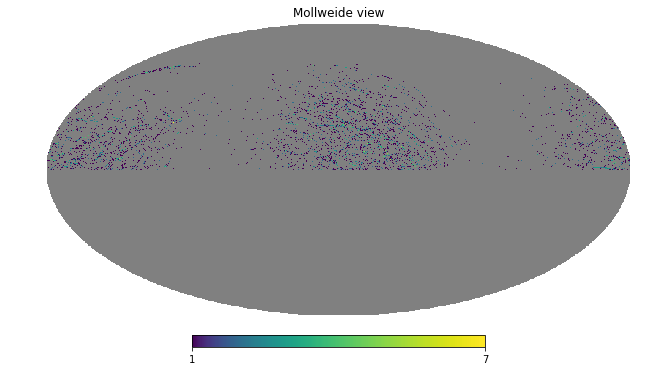

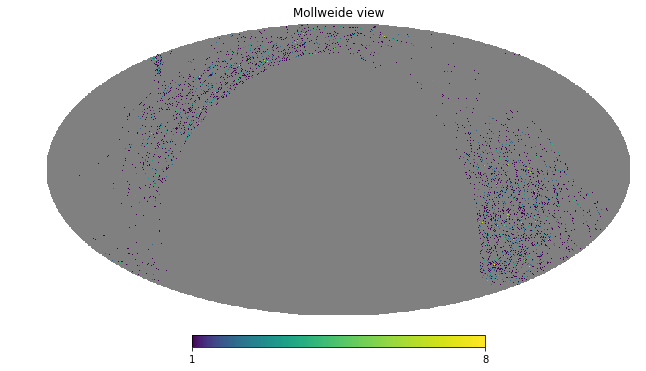

In [30]:
#paint max S2N on pixel 
nmap = np.bincount(pixnum, minlength=hp.npix)
mapSky = healpy.mollview(nmap, return_projected_map=True, min=1, norm='log')
plt.savefig('polesGal.pdf')
nmap = np.bincount(pixnumEq, minlength=hp.npix)
mapSky = healpy.mollview(nmap, return_projected_map=True, min=1, norm='log')
plt.savefig('polesEq.pdf')

#show 

In [33]:
print(poles)
print(polesEq)

<Galactic Coordinate: (l, b) in deg
    [( 55.5     ,  56.637198), ( 56.5     ,  56.637198),
     ( 57.5     ,  56.637198), ..., ( 39.726562,   0.      ),
     ( 39.726562,   0.      ), ( 39.726562,   0.      )]>
<ICRS Coordinate: (ra, dec) in deg
    [( 230.98401238,  34.65803686), ( 230.95087493,  35.20729919),
     ( 230.90742405,  35.75609356), ..., ( 285.96927097,   6.04418585),
     ( 285.96927097,   6.04418585), ( 285.96927097,   6.04418585)]>


In [31]:
s2nmap = np.ones(hp.npix)
s2nmapEq = np.ones(hp.npix)
uniqValues, uniqInverse = np.unique(pixnum, return_inverse=True)
uniqValuesEq = np.unique(pixnumEq)
#plt.plot(uniqInverse)
data['s2n'][np.isinf(data['s2n'])] = 0.
for v in uniqValues:
    s2n = np.max(data['s2n'][pixnum == v])
    s2nmap[v] = s2n
for v in uniqValuesEq:
    s2n = np.max(data['s2n'][pixnumEq == v])
    s2nmapEq[v] = s2n

Sigma is 34.377468 arcmin (0.010000 rad) 
-> fwhm is 80.952750 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.0 7.510877
786432
Sigma is 34.377468 arcmin (0.010000 rad) 
-> fwhm is 80.952750 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.0 7.510877
786432


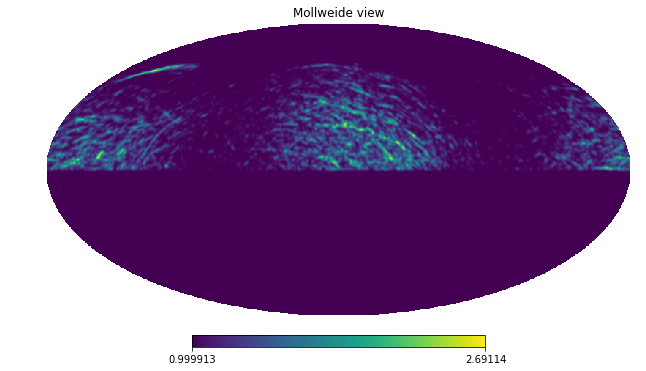

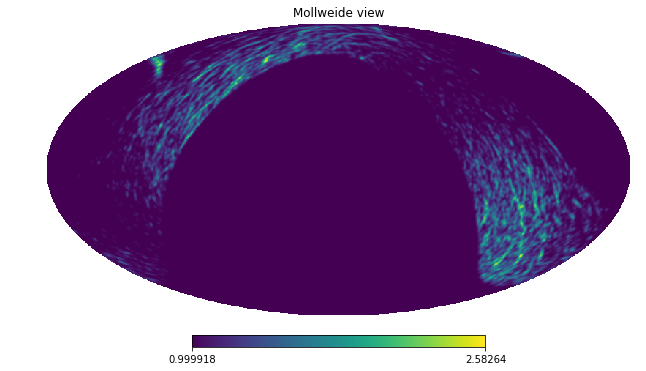

In [41]:
smoothmap = healpy.sphtfunc.smoothing(s2nmap, sigma=0.01, iter=1)
print(np.min(s2nmap), np.max(s2nmap))
print(np.sum(~np.isnan(smoothmap)))
healpy.mollview(smoothmap, return_projected_map=True) #, min=4, max=6) #, min=5, max=10) #, norm='log')
ax = plt.gca()
ax.grid()
plt.savefig('poless2n_galview.pdf')
smoothmap = healpy.sphtfunc.smoothing(s2nmapEq, sigma=0.01, iter=1)
print(np.min(s2nmap), np.max(s2nmap))
print(np.sum(~np.isnan(smoothmap)))
healpy.mollview(smoothmap, return_projected_map=True)#, min=4, max=6) #, min=5, max=10) #, norm='log')
plt.scatter(34.5987, 29.7331, color='black', s=10)
plt.savefig('poless2n_eqview.pdf')


In [69]:
from astropy.wcs import WCS
from astropy_healpix.core import boundaries_lonlat
step = 1
blah = hp.boundaries_skycoord(10, 1)
print(blah)
lon = lon.to(u.deg).value
lat = lat.to(u.deg).value
print(lon, lat)

<SkyCoord (Galactic): (l, b) in deg
    [[( 270.,  89.81725848), ( 270.,  89.6345165 ), ( 300.,  89.4517736 ),
      ( 315.,  89.6345165 )]]>


AttributeError: 'numpy.ndarray' object has no attribute 'to'

Text(0.5,1,'l centers')

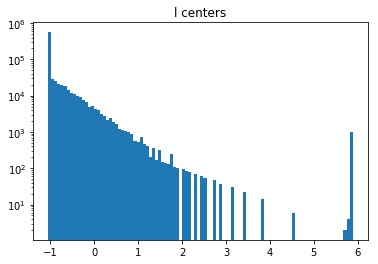

In [76]:
plt.hist(np.log(np.abs(centers[1:].l.value - centers[:-1].l.value)), bins=100, log = True)
plt.title('l centers')

In [ ]:
#color magnitude diagram of stream section 
rmag = data['psfmag_r'] - data['extinction_r']
gmag = data['psfmag_g'] - data['extinction_g']
colorbins = np.arange(0,   0.5+0.00001, 0.01)
magbins   = np.arange(18, 20.0+0.00001, 0.01)

lpoles = data['l'][0]
bpoles = data['b'][0]
phi1s  = data['phi1'][0]

#stream selection on sky
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
for lpole, bpole, phi1mid in zip(lpoles, bpoles, phi1s):
    pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
    index = (phi1 <= phi1mid+5) & (phi1 >= phi1mid-5)
    testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
    gal = testobserved.transform_to(coord.Galactic)
    eq = testobserved.transform_to(coord.ICRS)



#background selection on sky 

#2D hist of stream and background

#subtract background from stream 


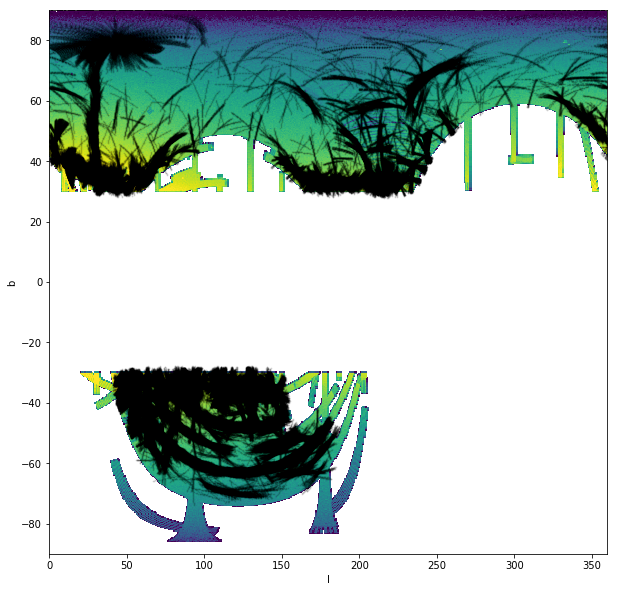

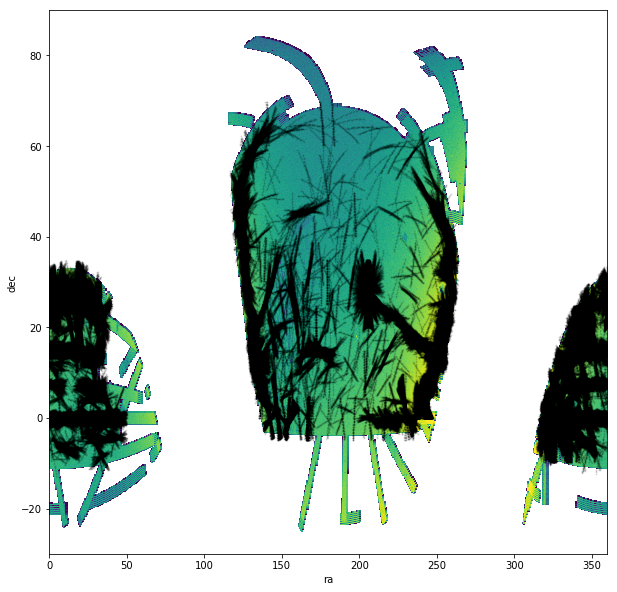

In [35]:
SNindex = (data['s2n'] <= 10) & (data['s2n'] > 5)
figGal, axGal = plotFootprint(stars['l'], stars['b'], None, nbins=500)
figEq, axEq = plotFootprint(stars['s_ra1'], stars['s_dec1'], None, nbins=500)
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
for lpole, bpole, phi1mid in zip(data['l'][SNindex], data['b'][SNindex], data['phi1'][SNindex]):
    pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
    index = (phi1 <= phi1mid+5) & (phi1 >= phi1mid-5)
    testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
    gal = testobserved.transform_to(coord.Galactic)
    eq = testobserved.transform_to(coord.ICRS)
    axGal.scatter(gal.l, gal.b, s=1, alpha=0.1, c='black')
    axEq.scatter(eq.ra, eq.dec, s=1, alpha=0.1, c='black')
for ax in [axGal, axEq]: ax.set_xlim(0, 360)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')
figGal.savefig('SNgalview_5to8.png')
figEq.savefig('SNeqview_5to8.png')